In [1]:
# Import required libraries for the IPL win probability prediction model.
import numpy as np                                     # For numerical operations
import pandas as pd                                    # For data manipulation
import matplotlib.pyplot as plt                        # For data visualization
from sklearn.compose import ColumnTransformer          # For column transformations
from sklearn.preprocessing import OneHotEncoder        # For one-hot encoding
from sklearn.linear_model import LogisticRegression    # For logistic regression model
from sklearn.ensemble import RandomForestClassifier    # For random forest model
from sklearn.pipeline import Pipeline                  # For creating a pipeline of transformers and estimator
import pickle                                          # For saving the trained model



In [2]:
# importing the deliveries and matches data for the IPL from the
# kaggle ipl dataset and sets them up as pandas dataframes for use in a win probability prediction model.
try:
    deliveries = pd.read_csv('deliveries.csv')
    matches = pd.read_csv('matches.csv')
except FileNotFoundError:
    print("One or both of the files could not be found.")


In [3]:
matches.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
matches.shape


(756, 18)

In [5]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [6]:
deliveries.shape


(179078, 21)

In [7]:
# Group the 'deliveries' dataframe by 'match_id' and 'inning', then calculate the total runs scored for each combination.
# The resulting dataframe includes the 'match_id', 'inning', and 'total_runs' columns.
total_score_by_inning_df = deliveries.groupby(['match_id','inning']).sum()['total_runs'].reset_index()
total_score_by_inning_df

,match_id,inning,total_runs
0,1,1,207
1,1,2,172
2,2,1,184
3,2,2,187
4,3,1,183
...,...,...,...
1523,11413,2,170
1524,11414,1,155
1525,11414,2,162
1526,11415,1,152


In [8]:
# Filter the 'total_score_by_inning_df' dataframe to only include rows where 'inning' equals 1.
# This creates a new dataframe with the same columns, but only includes data from the first inning of each match.
total_score_by_inning_df = total_score_by_inning_df[total_score_by_inning_df['inning'] == 1]


In [9]:
total_score_by_inning_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [10]:
#merging the matches and total_score_by_inning_df dataframes using a left join,
#resulting in a new dataframe called matches_df that includes data from both dataframes but only for matches where inning 1 data was available.
matches_df = matches.merge(total_score_by_inning_df[['match_id','total_runs']],left_on='id',right_on='match_id')


In [11]:
matches_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [12]:
matches_df['team1'].unique()


array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [13]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [14]:
# updating the team names in the matches_df dataframe to match the current names used in the IPL. 
matches_df['team1'] = matches_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
matches_df['team2'] = matches_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

matches_df['team1'] = matches_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matches_df['team2'] = matches_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [15]:
#filters the matches_df dataframe using two chained boolean conditions that check if each team name in the team1 and team2 columns is present in the teams list, using the isin() method. 
matches_df = matches_df[matches_df['team1'].isin(teams)]
matches_df = matches_df[matches_df['team2'].isin(teams)]

In [16]:
matches_df.shape

(641, 20)

In [17]:
#filters the matches_df dataframe to only include matches where the dl_applied column is equal to 0
matches_df = matches_df[matches_df['dl_applied'] == 0]

In [18]:
matches_df = matches_df[['match_id','city','winner','total_runs']]


In [19]:
deliveries_df = matches_df.merge(deliveries,on='match_id')


In [20]:
deliveries_df = deliveries_df[deliveries_df['inning'] == 2]


In [21]:
deliveries_df


,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [22]:
#Adds a new column to the deliveries_df dataframe called current_score that calculates the cumulative sum of runs scored up to the current ball in each match,
#using the groupby() and cumsum() methods.
deliveries_df['current_score'] = deliveries_df.groupby('match_id').cumsum()['total_runs_y']


In [23]:
#calculating the run left
deliveries_df['runs_left'] = deliveries_df['total_runs_x'] - deliveries_df['current_score'] 


In [24]:
#calculating the balls left
deliveries_df['balls_left'] = 126 - (deliveries_df['over']*6 + deliveries_df['ball'])



In [25]:
deliveries_df


,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,206,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,204,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,200,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,0,4
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-2,3
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-3,2
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-5,1


In [26]:
# Replace missing values in 'player_dismissed' column with 0
deliveries_df['player_dismissed'] = deliveries_df['player_dismissed'].fillna("0")

# Convert non-zero values in 'player_dismissed' column to 1
deliveries_df['player_dismissed'] = deliveries_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")

# Convert 'player_dismissed' column to integer data type
deliveries_df['player_dismissed'] = deliveries_df['player_dismissed'].astype('int')

# Calculate cumulative sum of 'player_dismissed' column grouped by 'match_id'
wickets = deliveries_df.groupby('match_id').cumsum()['player_dismissed'].values

# Calculate total number of wickets remaining for the batting team in each ball of the match
deliveries_df['wickets'] = 10 - wickets

# Print the first few rows of the updated dataframe
deliveries_df.head()


,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,206,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,204,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,200,115,10


In [27]:
deliveries_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,206,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,204,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,200,115,10


In [28]:
#current-run-rate (crr)=runs/overs
deliveries_df['crr'] = (deliveries_df['current_score']*6)/(120 - deliveries_df['balls_left'])


In [29]:
#calculate the required run rate
deliveries_df['rrr'] = (deliveries_df['runs_left']*6)/deliveries_df['balls_left']


In [30]:
#checking whether the batting team are winning are not
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [31]:
deliveries_df['result'] = deliveries_df.apply(result,axis=1)


In [32]:
final_df = deliveries_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]


In [33]:
final_df = final_df.sample(final_df.shape[0])


In [34]:
final_df.sample()


,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
30129,Kings XI Punjab,Delhi Daredevils,Bloemfontein,30,20,6,120,5.4,9.0,1


In [35]:
#dropping those rows containing the NaN missing value
final_df.dropna(inplace=True)


In [36]:
final_df = final_df[final_df['balls_left'] != 0]


In [37]:
#splitting the X and y data in training and testing dataframes for building and evaluating model
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [38]:
X_train


,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr
82579,Rajasthan Royals,Kings XI Punjab,Chandigarh,49,40,8,145,7.200000,7.350000
137916,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,126,19,3,233,6.356436,39.789474
40076,Chennai Super Kings,Royal Challengers Bangalore,Chennai,79,65,9,161,8.945455,7.292308
144925,Delhi Capitals,Rajasthan Royals,Jaipur,52,27,8,196,9.290323,11.555556
149026,Delhi Capitals,Sunrisers Hyderabad,Visakhapatnam,90,63,10,171,8.526316,8.571429
...,...,...,...,...,...,...,...,...,...
68066,Chennai Super Kings,Rajasthan Royals,Jaipur,111,104,9,126,5.625000,6.403846
123562,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata,108,97,9,145,9.652174,6.680412
81112,Kings XI Punjab,Royal Challengers Bangalore,Bangalore,143,92,9,174,6.642857,9.326087
130423,Kings XI Punjab,Rajasthan Royals,Jaipur,84,45,6,161,6.160000,11.200000


In [39]:
#one-hot coding for the categorical variable
ct = ColumnTransformer([
    ('ct',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [40]:
#creating pipeline 
pipe = Pipeline(steps=[
    ('step1',ct),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [41]:
#fitting the pipeline "pipe" to the training data X_train and y_train.
pipe.fit(X_train,y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ct',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [42]:
y_pred = pipe.predict(X_test)

In [43]:
#checking the accuracy of the model/model evaluation
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8034900833975752

In [44]:
pipe.predict_proba(X_test)[10]

array([0.58996693, 0.41003307])

In [45]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

In [46]:
def matches_progression(x_df,match_id,pipe):
    # Filter matches by match_id and balls bowled at end of over
    matches = x_df[x_df['match_id'] == match_id]
    matches = matches[(matches['ball'] == 6)]
    
    # Select relevant columns and drop rows with null values and 0 balls left
    temp_df = matches[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    
    # Predict the probability of win or loss using the given model
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    
    # Add a column with the over number
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    # Calculate target score and runs scored after each over
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    
    # Calculate wickets lost in each over
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    # Print the target score and return the relevant columns
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target


In [47]:
temp_df,target = matches_progression(deliveries_df,74,pipe)
temp_df

Target- 178


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,0,57.1,42.9
10467,2,8,0,51.7,48.3
10473,3,1,0,58.6,41.4
10479,4,7,1,70.0,30.0
10485,5,12,0,60.0,40.0
10491,6,13,0,47.7,52.3
10497,7,9,0,41.8,58.2
10505,8,15,0,28.0,72.0
10511,9,7,0,25.8,74.2
10518,10,17,0,14.2,85.8


Text(0.5, 1.0, 'Target-178')

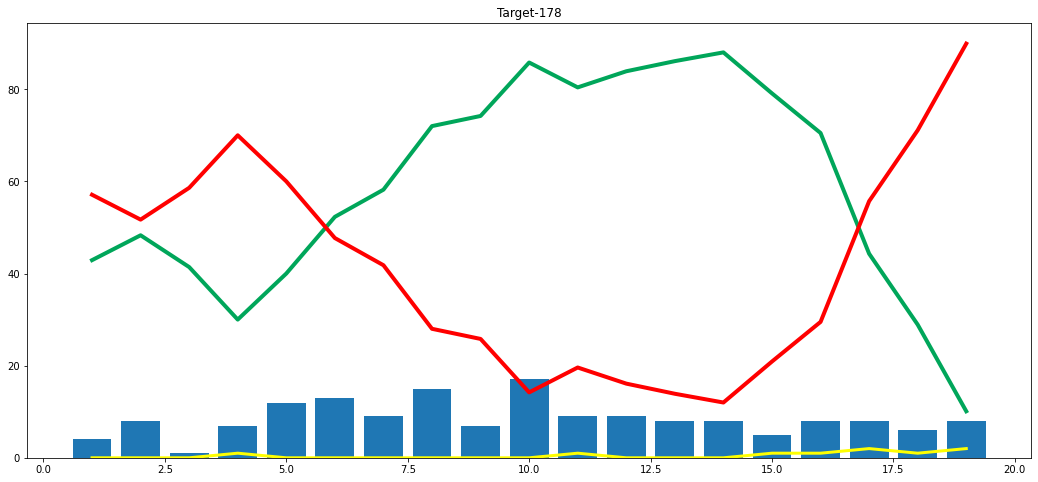

In [48]:
#a visual representation of the match progress for a given match using Matplotlib
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [49]:
#using the pickle module to save the pipe object to a file named pipe.pkl in binary mode ('wb'). 
#This file can later be loaded (unpickled) and used to make predictions without needing to retrain the pipeline every time.
pickle.dump(pipe,open('pipe.pkl','wb'))